# Inspiration from
- https://www.kaggle.com/code/cabaxiom/s5e1-eda-and-linear-regression-baseline
- https://www.kaggle.com/code/sunilkumarmuduli/complete-tutorial-model-time-series-eda


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# Read Data
train = pd.read_csv('data/train.csv', parse_dates=['date'])
test = pd.read_csv('data/test.csv', parse_dates=['date'])
submission_sample = pd.read_csv('data/sample_submission.csv')

In [5]:
display(train.head(3))
display(test.head(3))

id       date country              store            product  num_sold
0   0 2010-01-01  Canada  Discount Stickers  Holographic Goose       NaN
1   1 2010-01-01  Canada  Discount Stickers             Kaggle     973.0
2   2 2010-01-01  Canada  Discount Stickers       Kaggle Tiers     906.0

id       date country              store            product
0  230130 2017-01-01  Canada  Discount Stickers  Holographic Goose
1  230131 2017-01-01  Canada  Discount Stickers             Kaggle
2  230132 2017-01-01  Canada  Discount Stickers       Kaggle Tiers

In [5]:
print("Shape of TRAIN data:",train.shape)
print("Shape of TEST data:", test.shape)

Shape of traing data: (230130, 6)
Shape of testing data: (98550, 5)


# Basic Dataset Stats

In [10]:
# Basic statistics for train dataframe
print("Train DataFrame Statistics:")
print(train.info())
print("\nNumeric Features:")
print(train.describe().round(2))
print("\nCategorical Features:")
print(train.describe(include=['object']))
print("\n\n")



nulls = train.isna().sum()
print('Train DataFrame Null Values:')
print(pd.DataFrame({
    'Count': nulls,
    '% of Total': (nulls/len(train)*100).round(1)
}).sort_values('Count', ascending=False))
print("\n")

print("Train DataFrame Unique Values:")
print(train.nunique())
print("\n")



Train DataFrame Statistics:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        230130 non-null  int64  
 1   date      230130 non-null  object 
 2   country   230130 non-null  object 
 3   store     230130 non-null  object 
 4   product   230130 non-null  object 
 5   num_sold  221259 non-null  float64
dtypes: float64(1), int64(1), object(4)
memory usage: 10.5+ MB
None

Numeric Features:
              id   num_sold
count  230130.00  221259.00
mean   115064.50     752.53
std     66432.95     690.17
min         0.00       5.00
25%     57532.25     219.00
50%    115064.50     605.00
75%    172596.75    1114.00
max    230129.00    5939.00

Categorical Features:
              date country              store            product
count       230130  230130             230130             230130
unique        2557       6                  3     

In [11]:
# Distribution of categorical features
cat_features = train.select_dtypes(include=['object']).columns
for cat in cat_features:
    print(f'{cat} Distribution:')
    # Get the counts and percentages
    counts = train[cat].value_counts()
    percentages = train[cat].value_counts(normalize=True).round(2) * 100
    # Combine into a DataFrame for better readability
    dist_df = pd.DataFrame({'Count': counts, 'Percentage (%)': percentages})
    print(dist_df)
    print("\n")

country Distribution:
           Count  Percentage (%)
country                         
Canada     38355            17.0
Finland    38355            17.0
Italy      38355            17.0
Kenya      38355            17.0
Norway     38355            17.0
Singapore  38355            17.0


store Distribution:
                      Count  Percentage (%)
store                                      
Discount Stickers     76710            33.0
Stickers for Less     76710            33.0
Premium Sticker Mart  76710            33.0


product Distribution:
                    Count  Percentage (%)
product                                  
Holographic Goose   46026            20.0
Kaggle              46026            20.0
Kaggle Tiers        46026            20.0
Kerneler            46026            20.0
Kerneler Dark Mode  46026            20.0




<Figure size 1600x600 with 0 Axes>

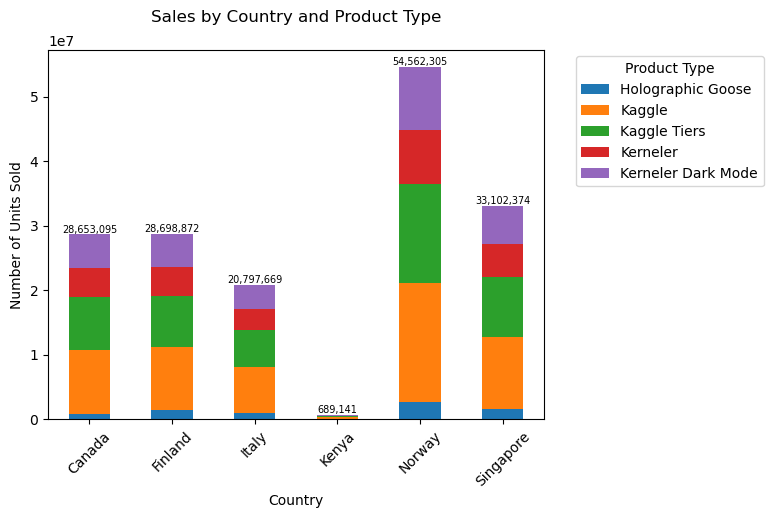

In [20]:
# Observe the Units sold with respect to the categorical features
plt.figure(figsize=(16, 6))
sales_by_country = train.pivot_table(index='country', columns='product', values='num_sold', aggfunc='sum')
ax = sales_by_country.plot(kind='bar', stacked=True)

# Add value labels on each segment
totals = sales_by_country.sum(axis=1)
for i, total in enumerate(totals):
    ax.text(i, total, f'{int(total):,}', ha='center', va='bottom', fontsize=7)

plt.title('Sales by Country and Product Type', pad=20)
plt.xlabel('Country')
plt.ylabel('Number of Units Sold')
plt.legend(title='Product Type', bbox_to_anchor=(1.05, 1))
plt.xticks(rotation=45)

plt.show()

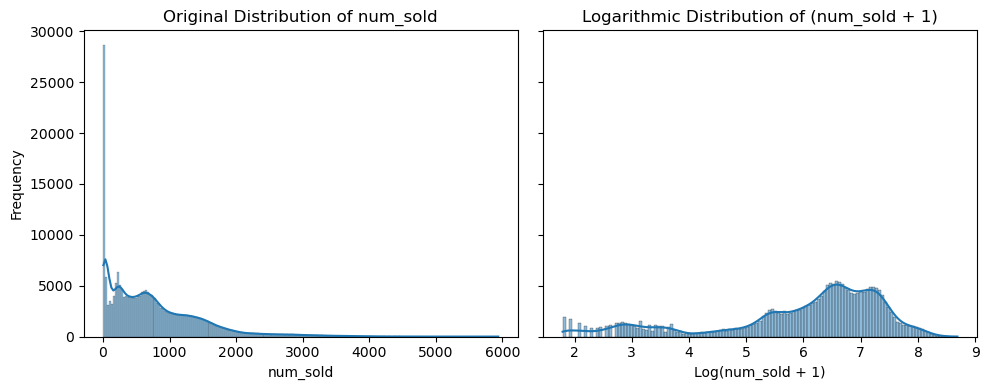

In [14]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# Original distribution
sns.histplot(data=train, x='num_sold', kde=True, ax=axes[0])
axes[0].set_title("Original Distribution of num_sold")
axes[0].set_xlabel("num_sold")
axes[0].set_ylabel("Frequency")

# Logarithmic distribution
sns.histplot(data=train, x=np.log1p(train['num_sold']), kde=True, ax=axes[1])
axes[1].set_title("Logarithmic Distribution of (num_sold + 1)")
axes[1].set_xlabel("Log(num_sold + 1)")
axes[1].set_ylabel("Frequency")

# Show the plots
plt.tight_layout()
plt.show()

In [18]:
# Group the dataset by 'country', 'store', and 'product', and count the number of rows for each group
counts = (
    train.groupby(["country", "store", "product"])["id"]
    .count()
    .rename("num_rows")
    .reset_index()
)
# Count how many groups have each unique row count (num_rows)
counts_val_counts = (
    counts["num_rows"]
    .value_counts()
    .rename("Count")
    .reset_index()
    .rename(columns={"index": "length"})
)
display(counts_val_counts)


num_rows  Count
0      2557     90

In [19]:
# Identify Missing Value in `num_sold` for each group
counts = (
    train.groupby(["country", "store", "product"])["num_sold"]
    .count()
    .rename("num_rows")
)
missing_data = counts.loc[counts != 2557]
missing_data_df = missing_data.reset_index()
missing_data_df["num_missing_rows"] = 2557 - missing_data_df["num_rows"]
missing_data_df

country                 store             product  num_rows  \
0  Canada     Discount Stickers   Holographic Goose         0   
1  Canada     Discount Stickers            Kerneler      2556   
2  Canada  Premium Sticker Mart   Holographic Goose      2177   
3  Canada     Stickers for Less   Holographic Goose      1249   
4   Kenya     Discount Stickers   Holographic Goose         0   
5   Kenya     Discount Stickers            Kerneler      2494   
6   Kenya     Discount Stickers  Kerneler Dark Mode      2556   
7   Kenya  Premium Sticker Mart   Holographic Goose      1911   
8   Kenya     Stickers for Less   Holographic Goose      1199   

   num_missing_rows  
0              2557  
1                 1  
2               380  
3              1308  
4              2557  
5                63  
6                 1  
7               646  
8              1358

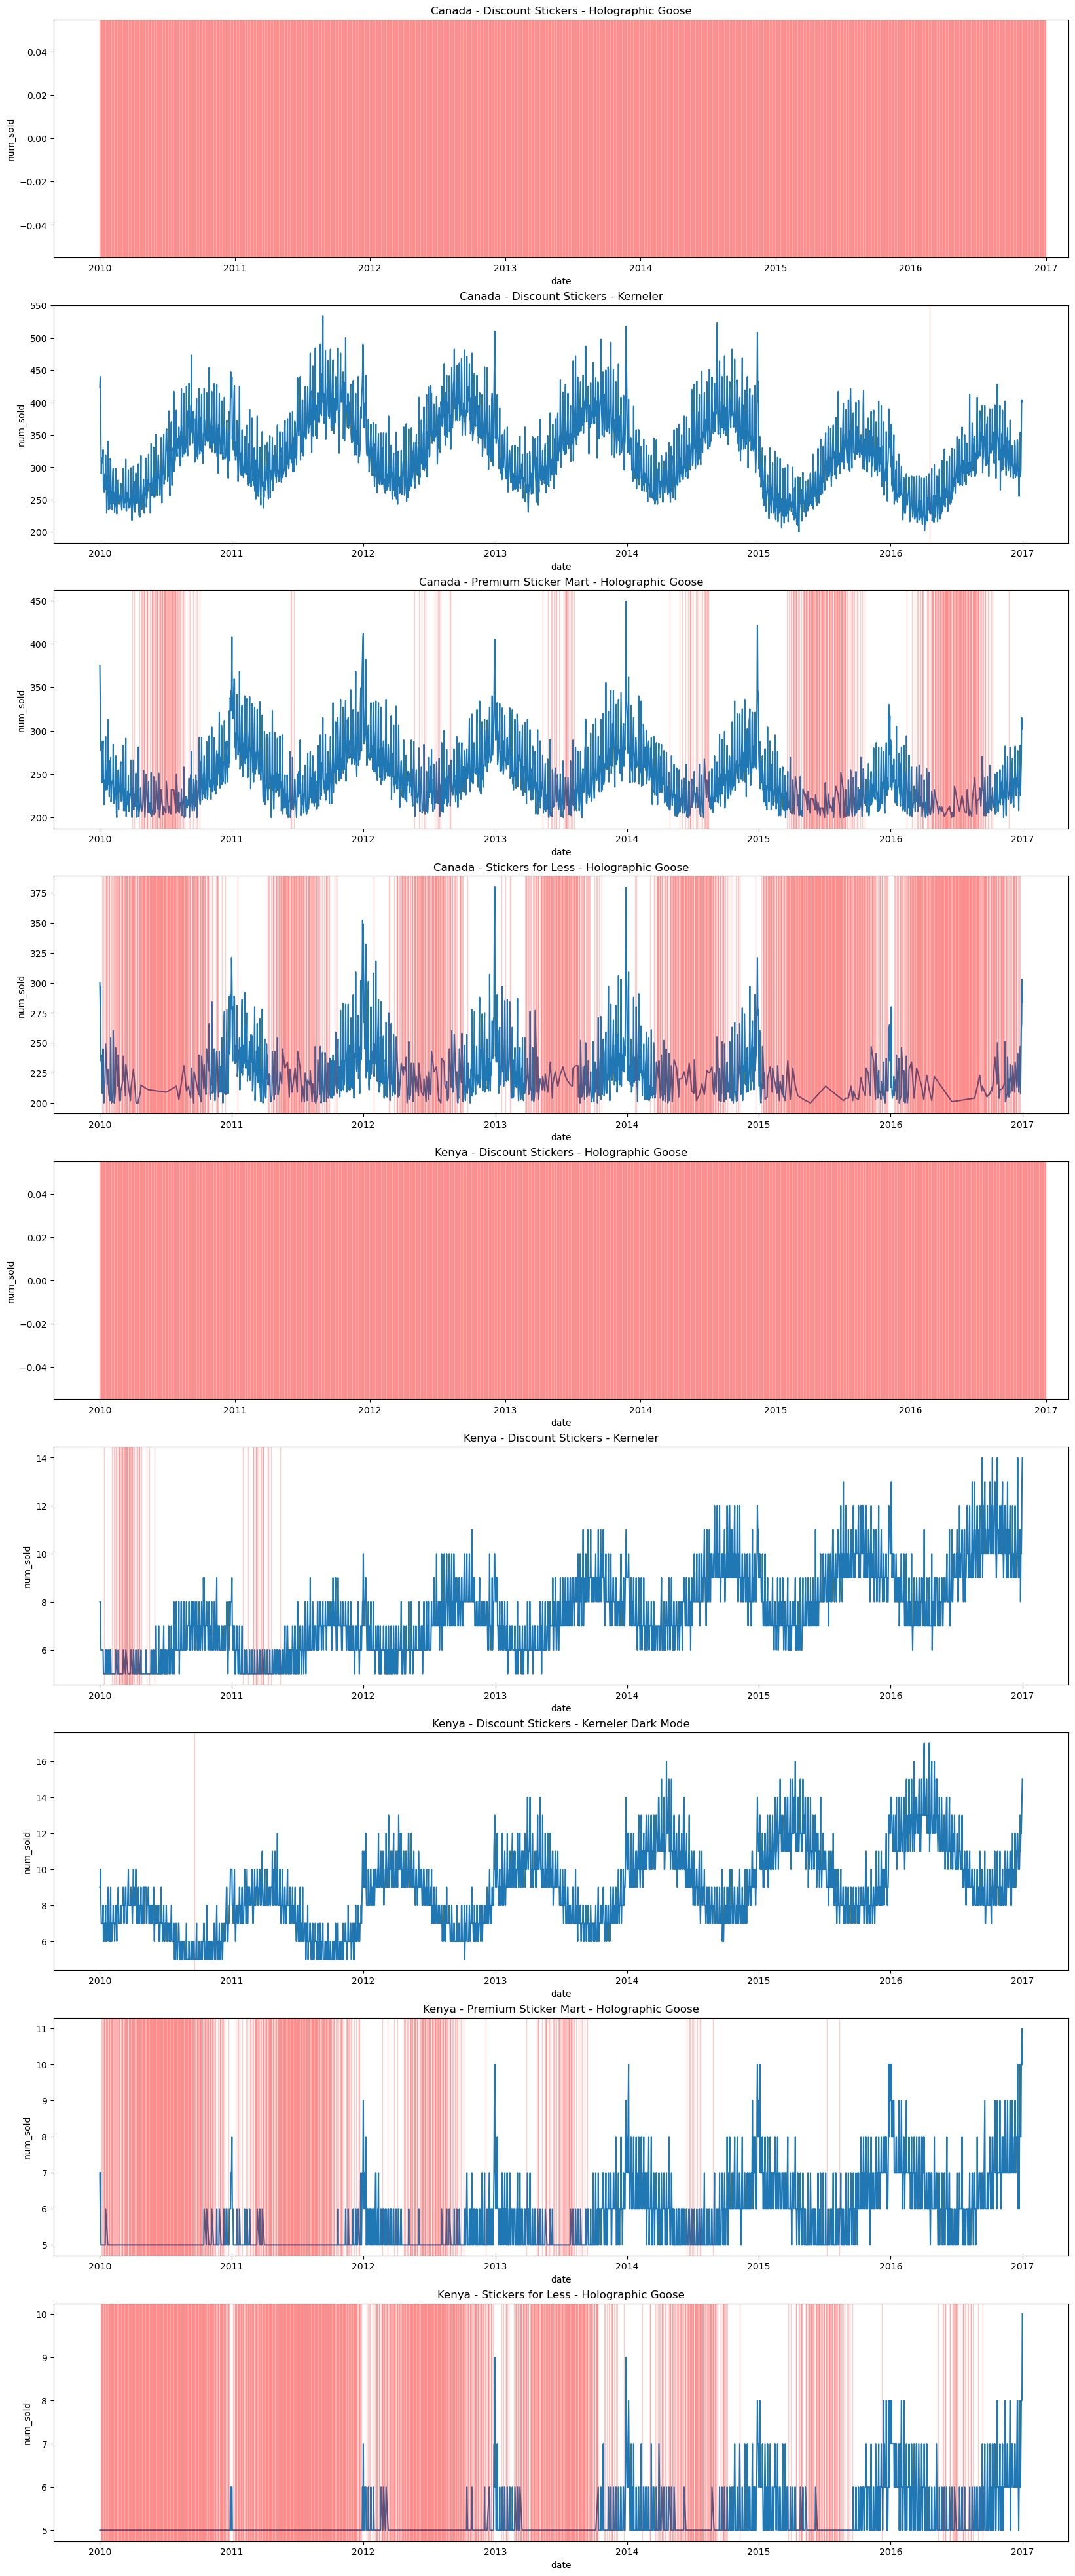

In [28]:
# Plot the Missing Values [NR]
f, axs = plt.subplots(9, 1, figsize=(20, 50))
for i, (country, store, product) in enumerate(missing_data.index):
    plot_df = train.loc[
        (train["country"] == country)
        & (train["store"] == store)
        & (train["product"] == product)
    ]
    missing_vals = plot_df.loc[plot_df["num_sold"].isna()]
    sns.lineplot(data=plot_df, x="date", y="num_sold", ax=axs[i])
    for missing_date in missing_vals["date"]:
        axs[i].axvline(missing_date, color="red", linestyle="-", linewidth=1, alpha=0.2)
    axs[i].set_title(f"{country} - {store} - {product}")

# Timeseries Analysis

In [24]:
print("TRAIN DATA")
print("Train - Earliest date:", train["date"].min())
print("Train - Latest date:", train["date"].max())

print("\nTEST DATA")
print("Test - Earliest date:", test["date"].min())
print("Test - Latest date:", test["date"].max())

TRAIN DATA
Train - Earliest date: 2010-01-01 00:00:00
Train - Latest date: 2016-12-31 00:00:00

TEST DATA
Test - Earliest date: 2017-01-01 00:00:00
Test - Latest date: 2019-12-31 00:00:00


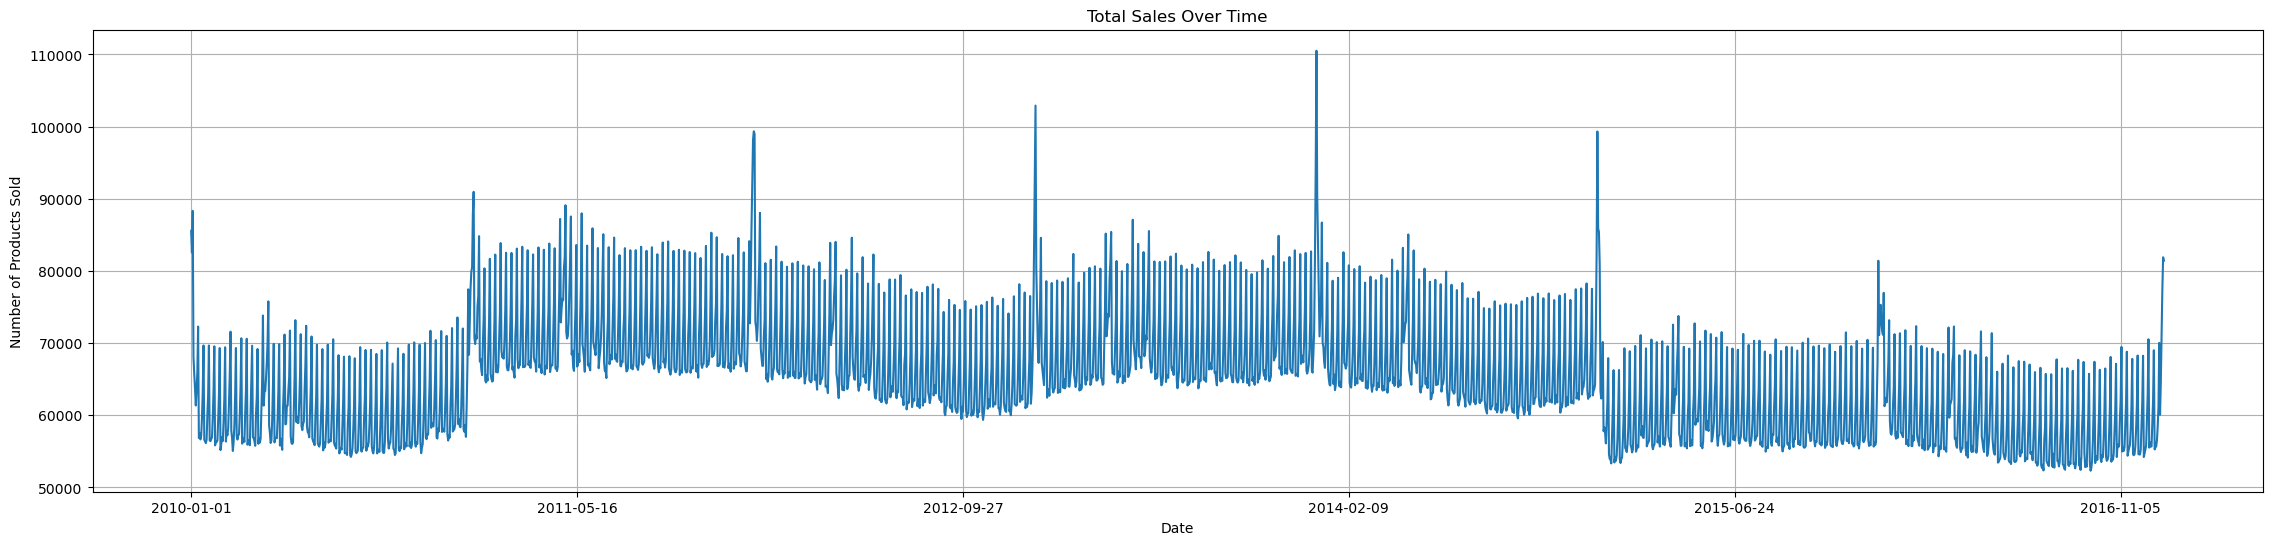

In [8]:
plt.figure(figsize=(28, 6))
train.groupby('date')['num_sold'].sum().plot(title='Total Sales Over Time', xlabel='Date', ylabel='Number of Products Sold')
plt.grid()
plt.show()

In [25]:
def plot_all(df):
    f,axes = plt.subplots(3,2,figsize=(20,20), sharex = True, sharey=True)
    f.tight_layout()
    for n,prod in enumerate(df["product"].unique()):
        plot_df = df.loc[df["product"] == prod]
        sns.lineplot(data=plot_df, x="date", y="num_sold", hue="country", style="store",ax=axes[n//2,n%2])
        axes[n//2,n%2].set_title("Product: "+str(prod))
        
weekly_df = train.groupby(["country","store", "product", pd.Grouper(key="date", freq="W")])["num_sold"].sum().rename("num_sold").reset_index()
monthly_df = train.groupby(["country","store", "product", pd.Grouper(key="date", freq="MS")])["num_sold"].sum().rename("num_sold").reset_index()


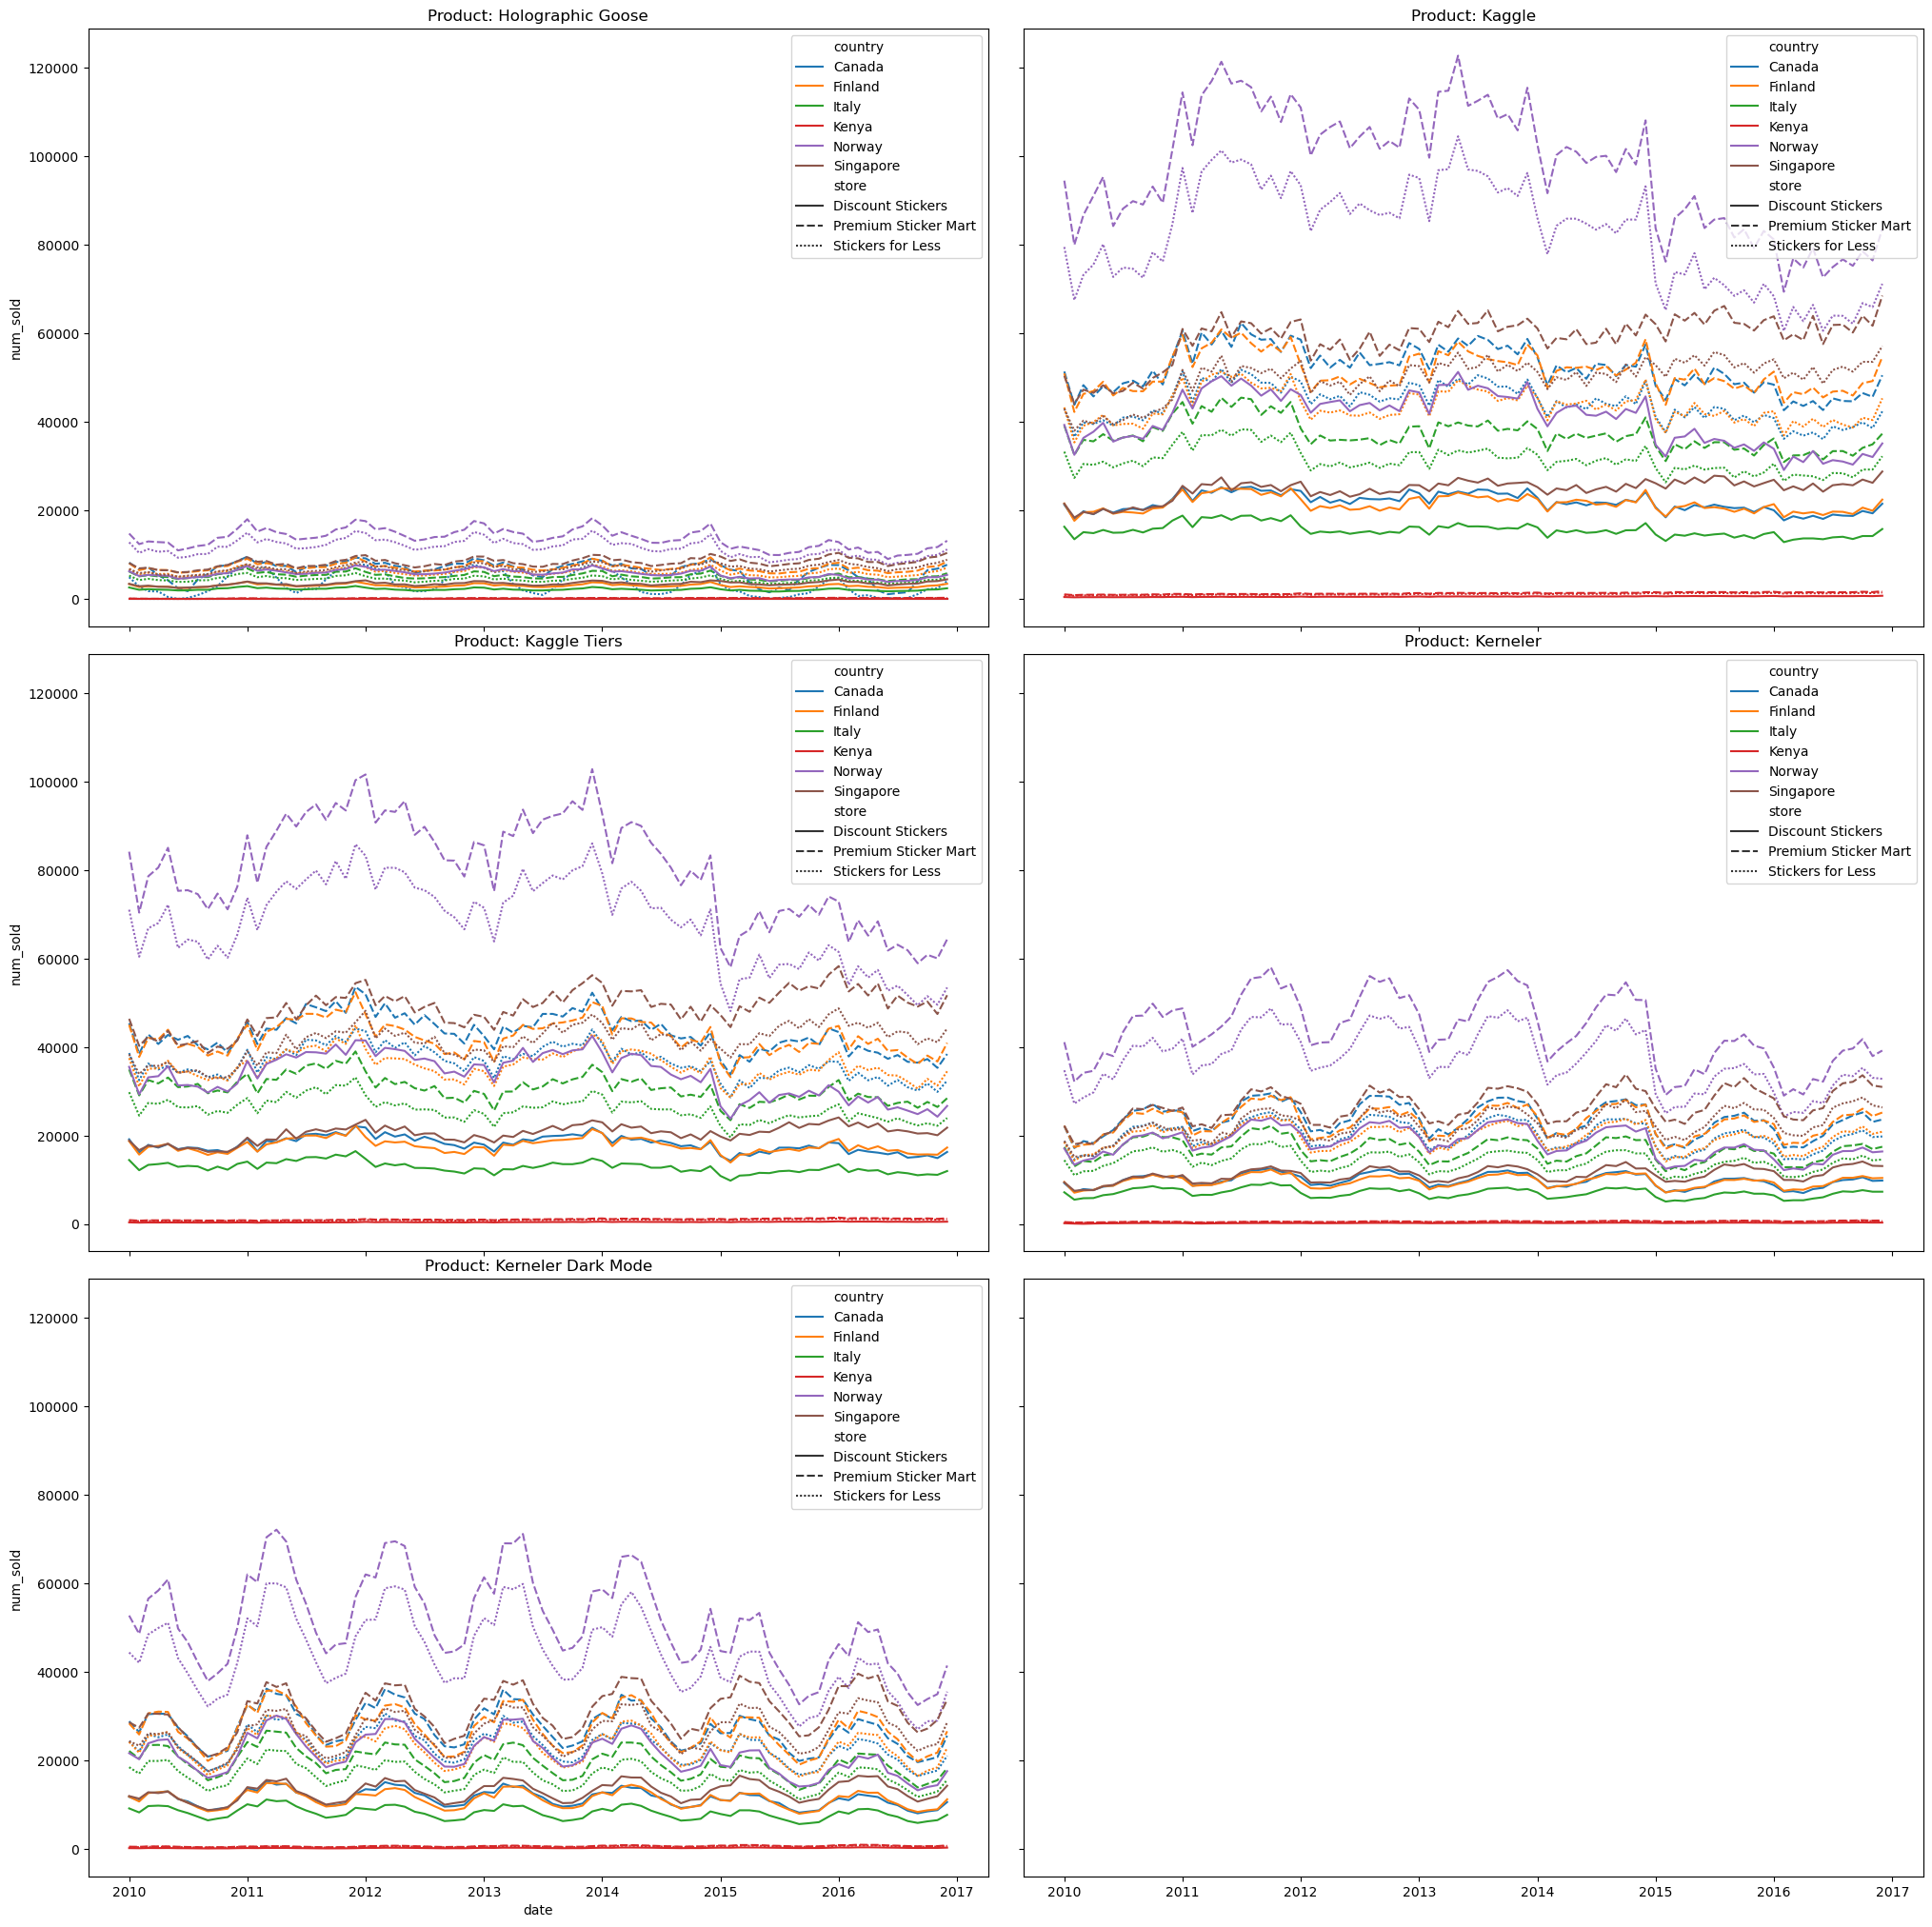

In [26]:
plot_all(monthly_df)

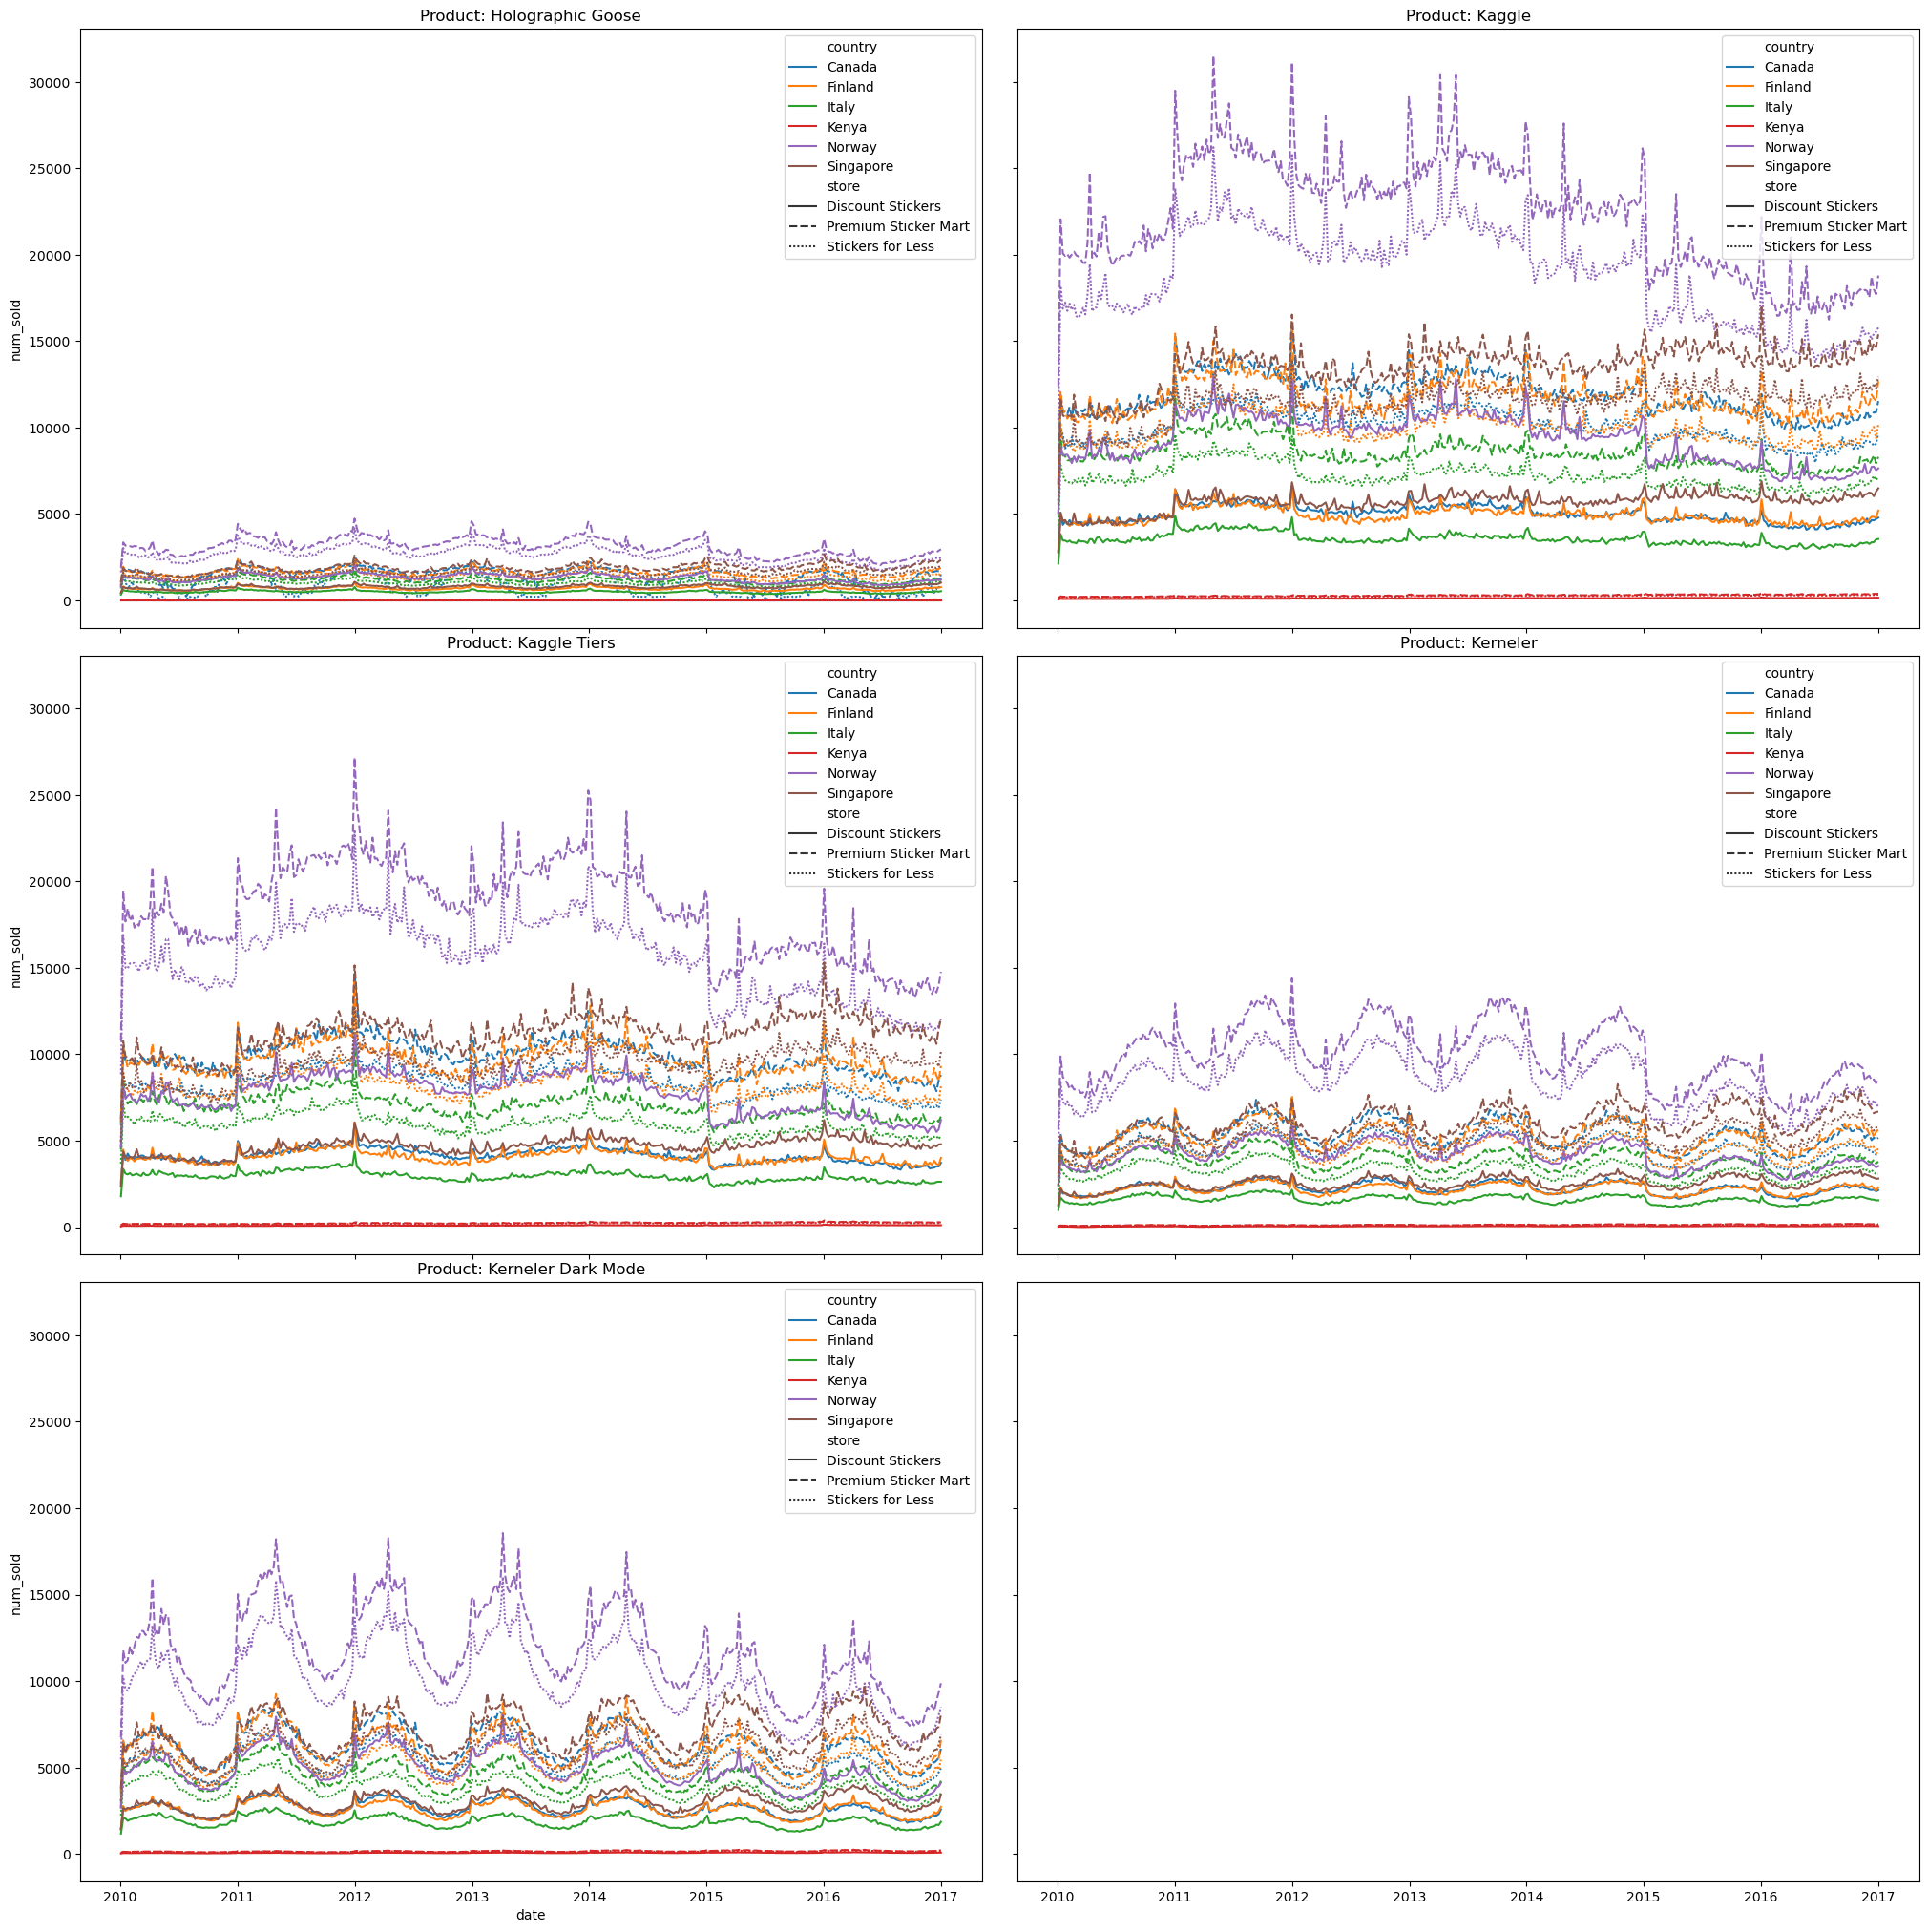

In [27]:
plot_all(weekly_df)

Text(0.5, 1.0, 'Monthly Sales Over Time')

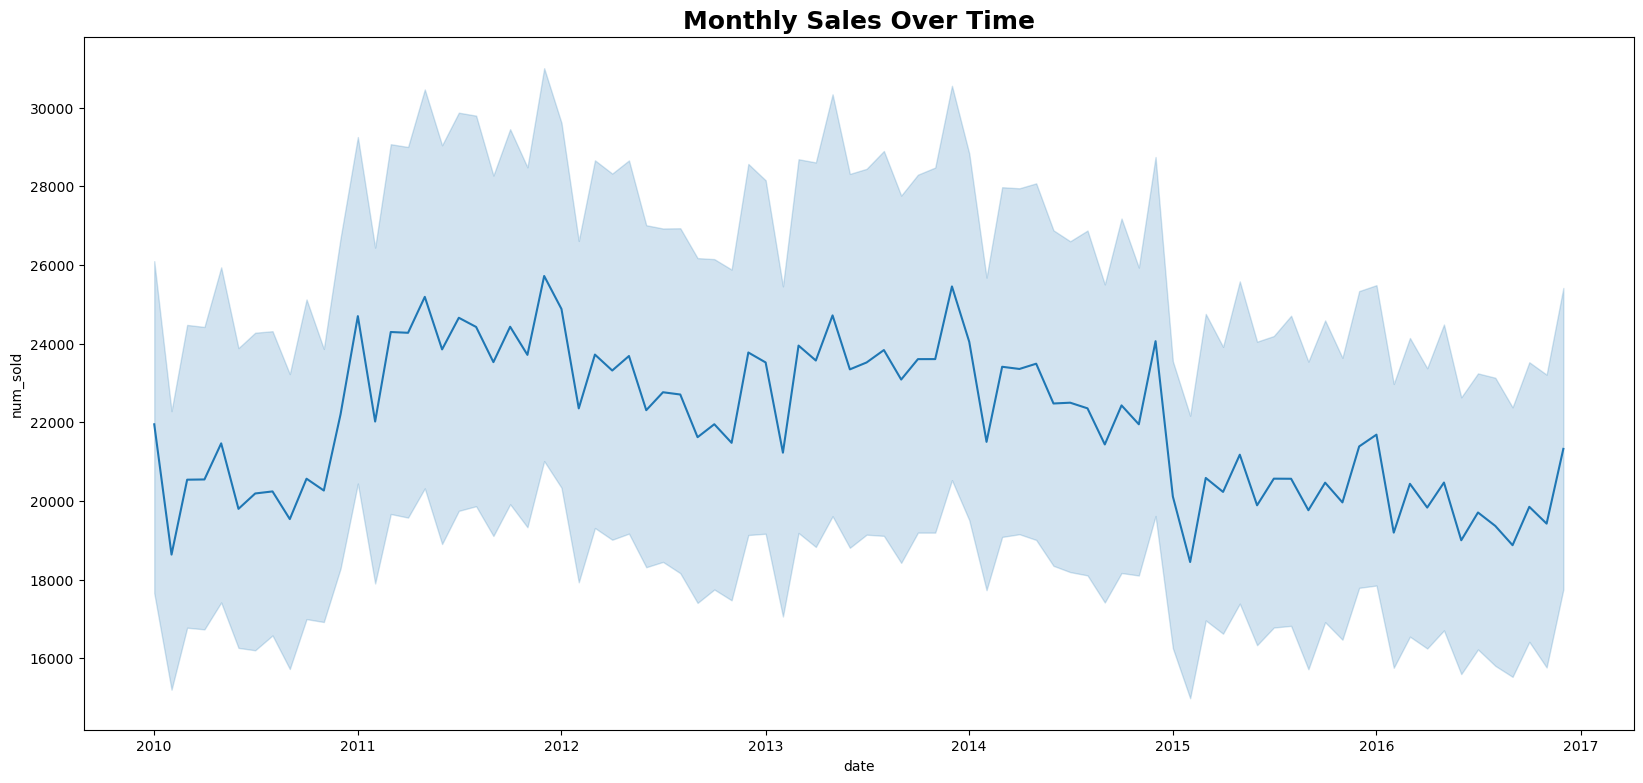

In [47]:
f,ax = plt.subplots(figsize=(20,9))
sns.lineplot(data=monthly_df, x="date", y="num_sold")
ax.set_title("Monthly Sales Over Time", fontsize=18, fontweight="bold")


Text(0.5, 1.0, 'Weekly Sales Over Time')

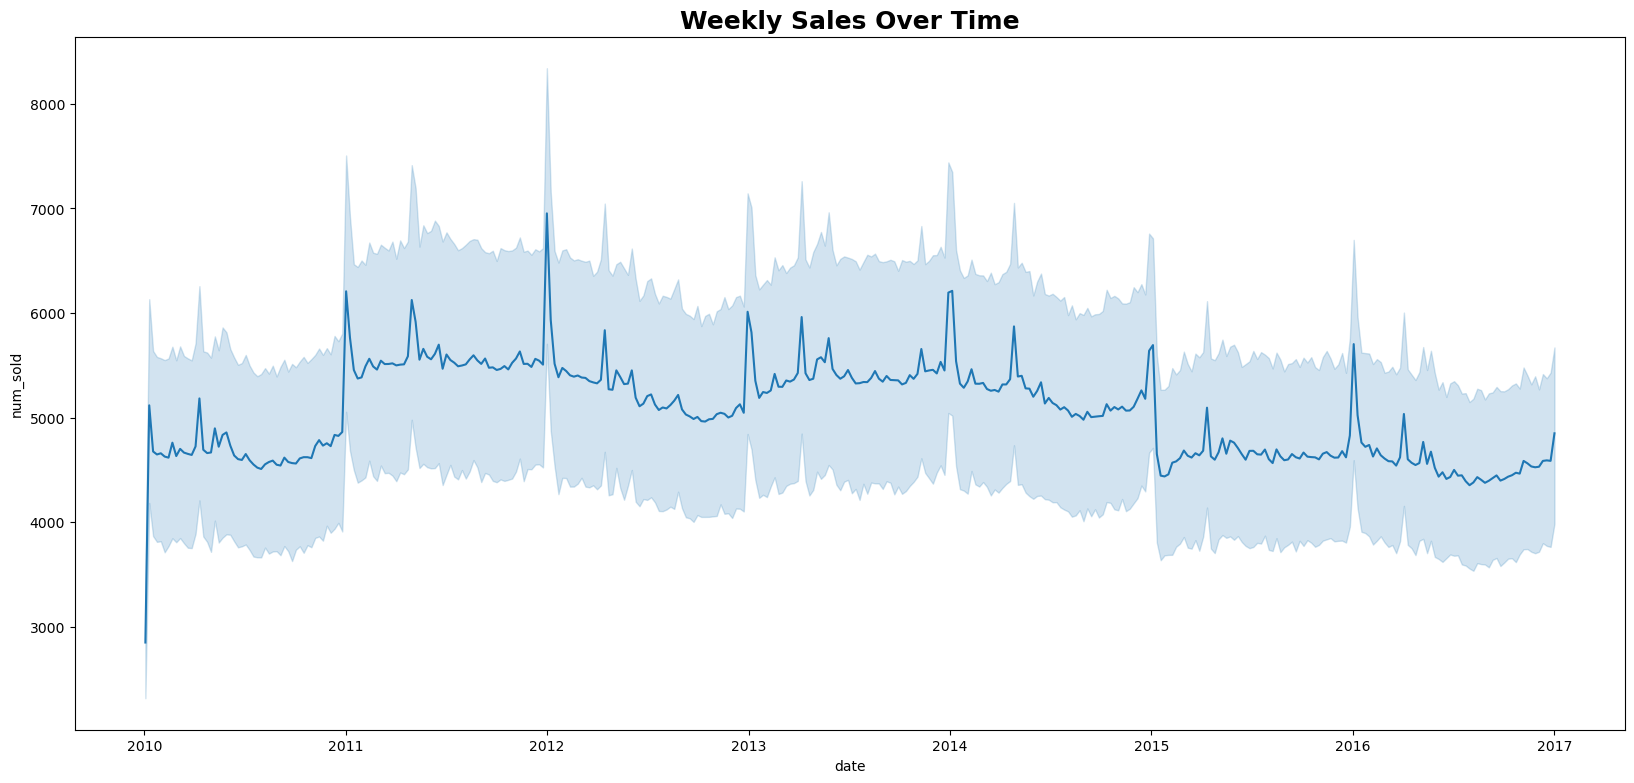

In [48]:
f,ax = plt.subplots(figsize=(20,9))
sns.lineplot(data=weekly_df, x="date", y="num_sold")
ax.set_title("Weekly Sales Over Time", fontsize=18, fontweight="bold")


## Seasonal Component

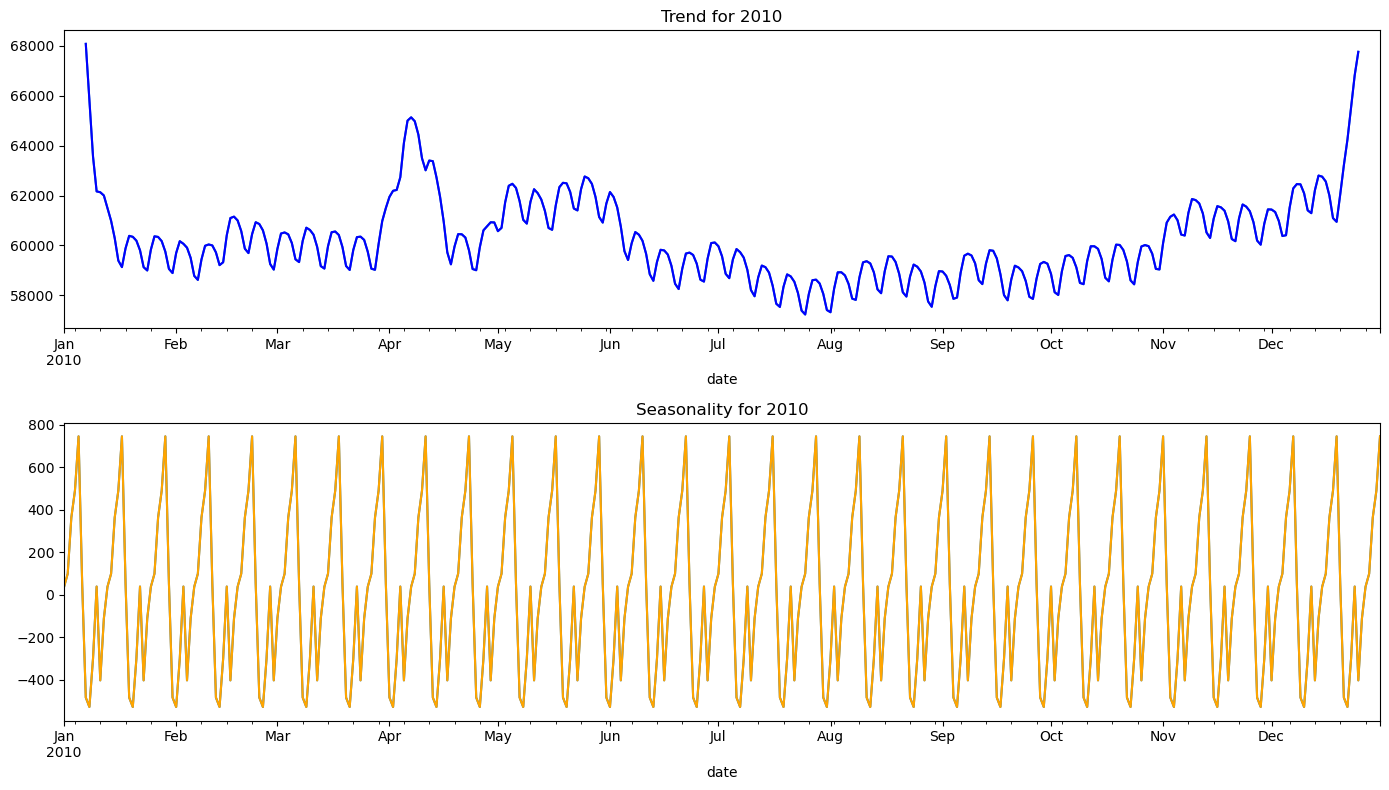

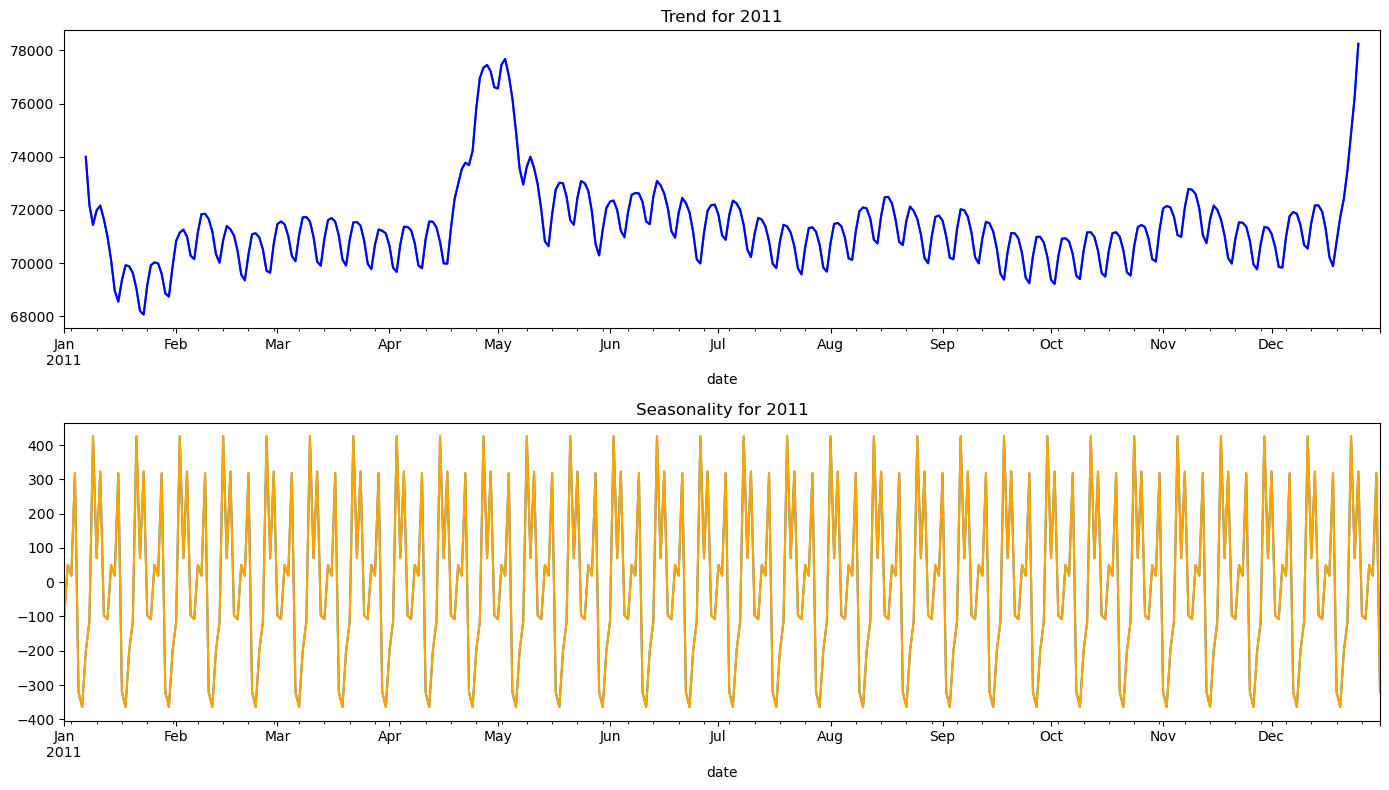

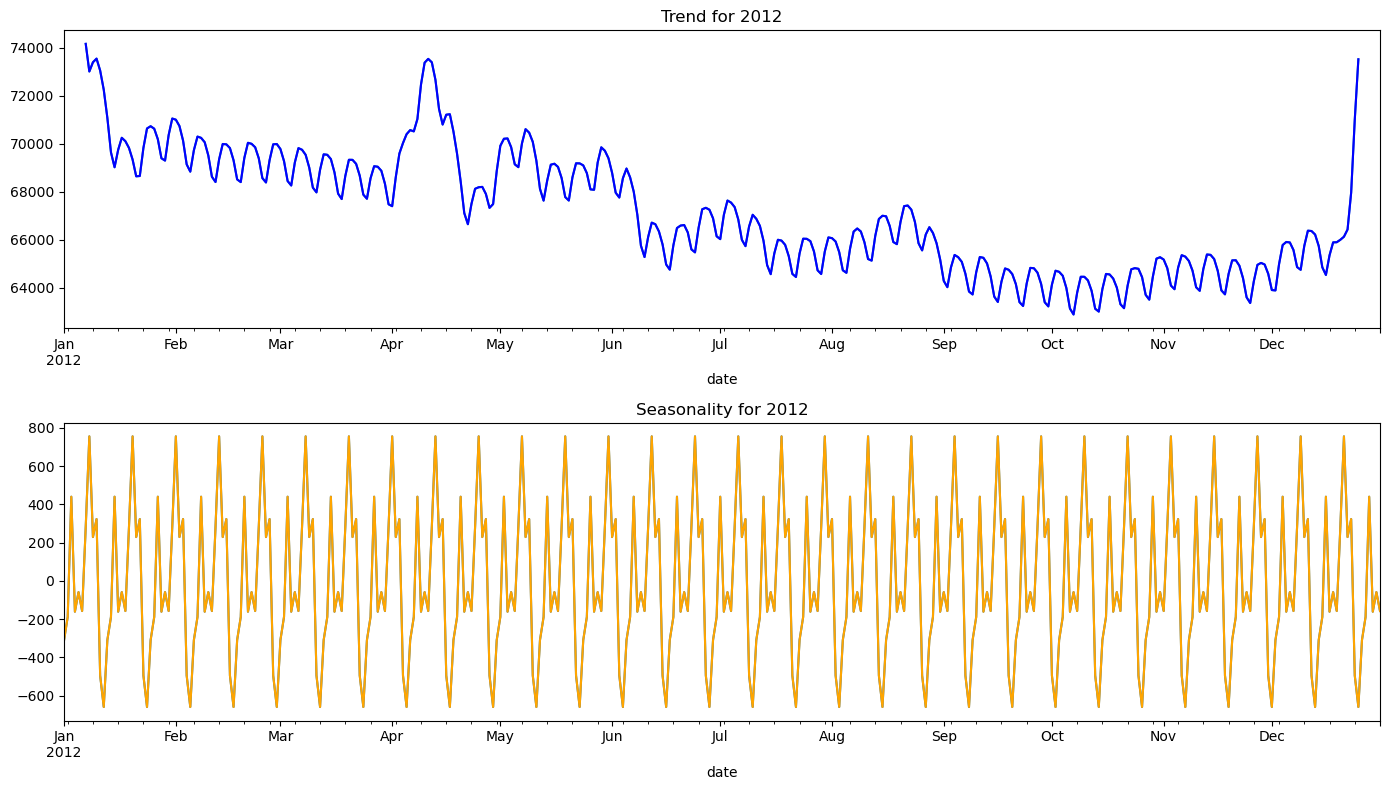

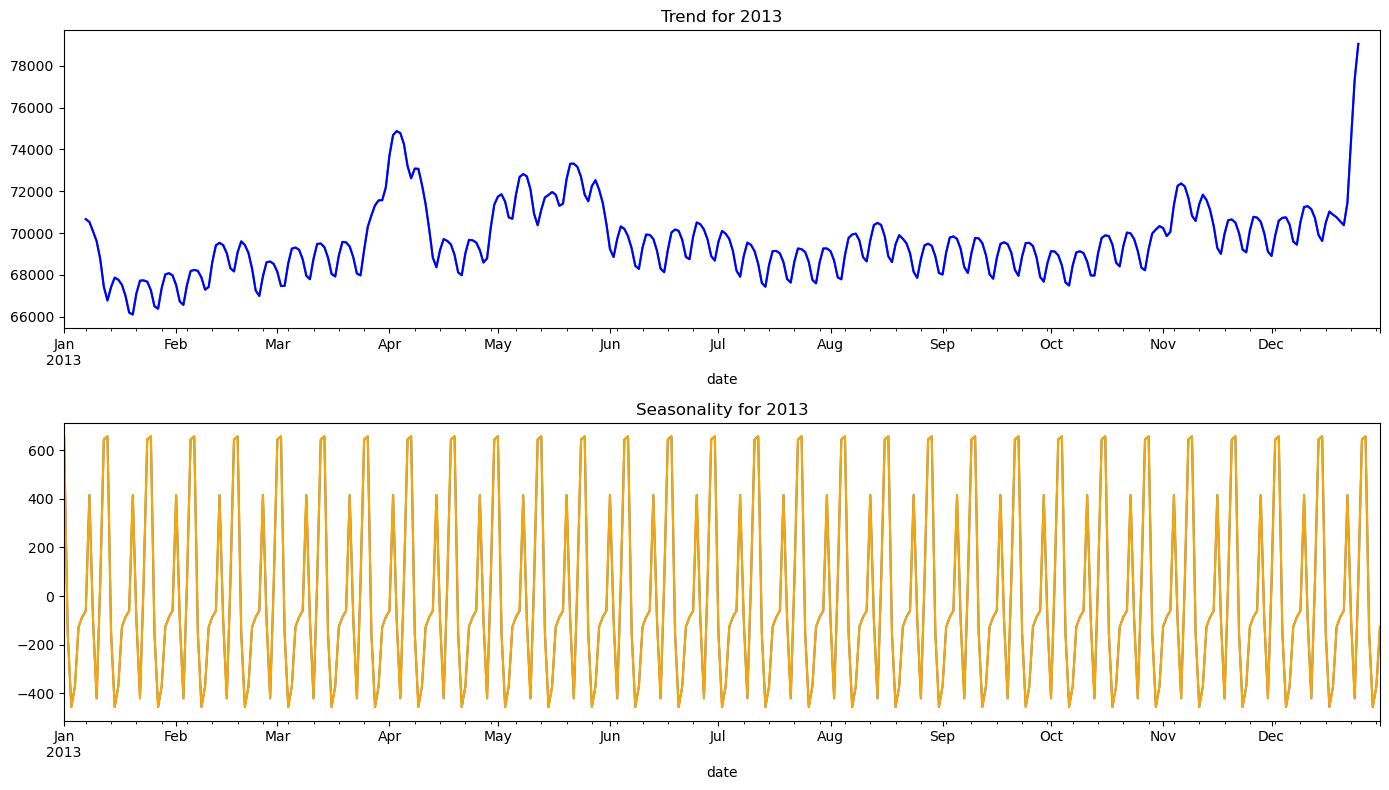

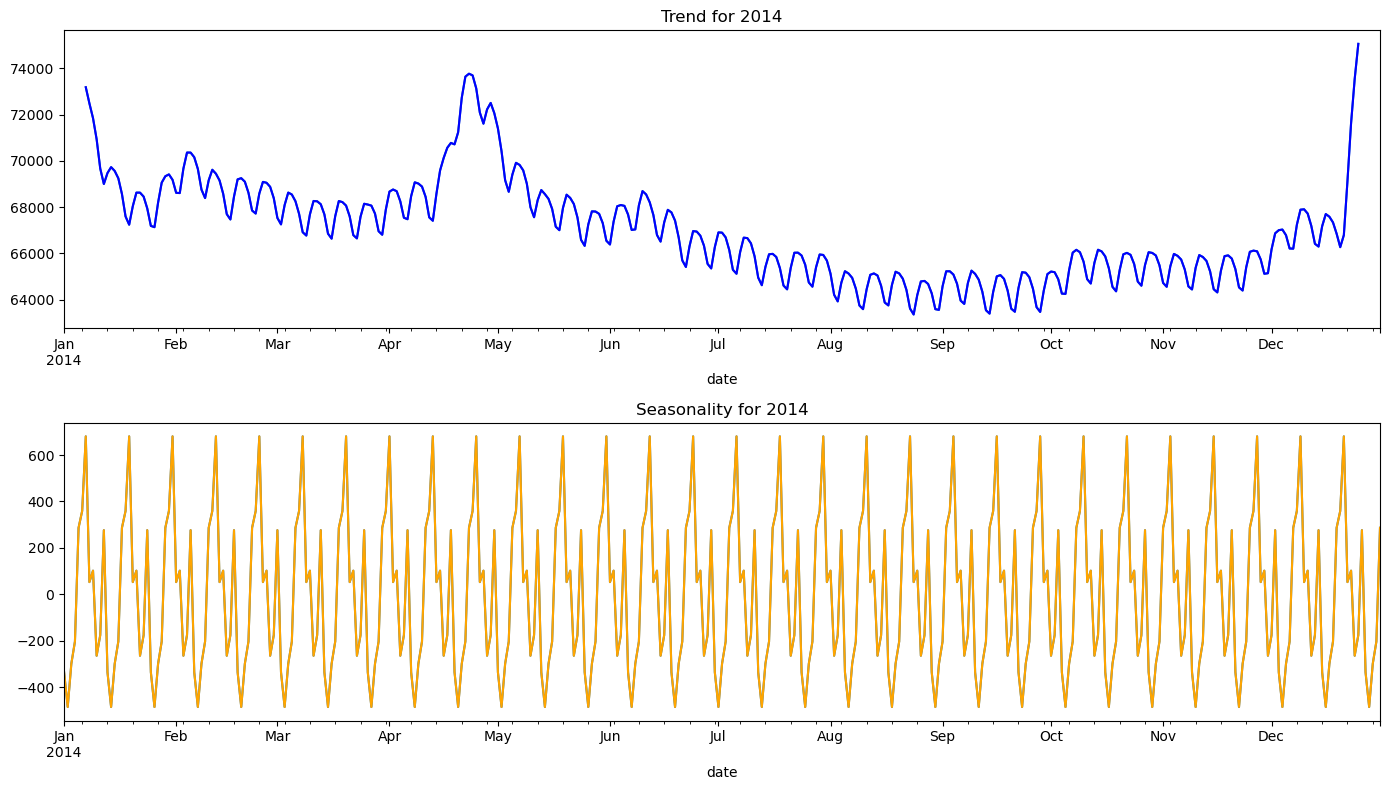

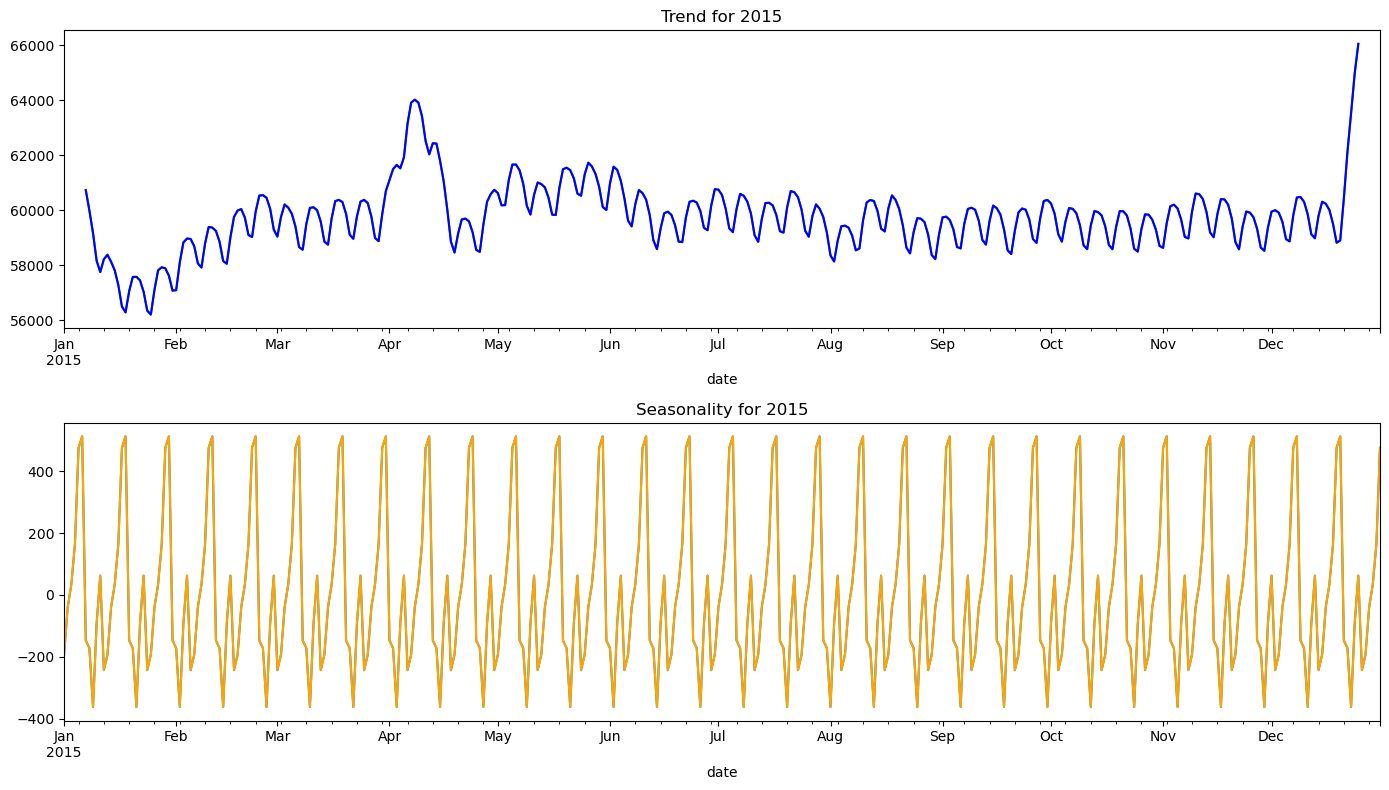

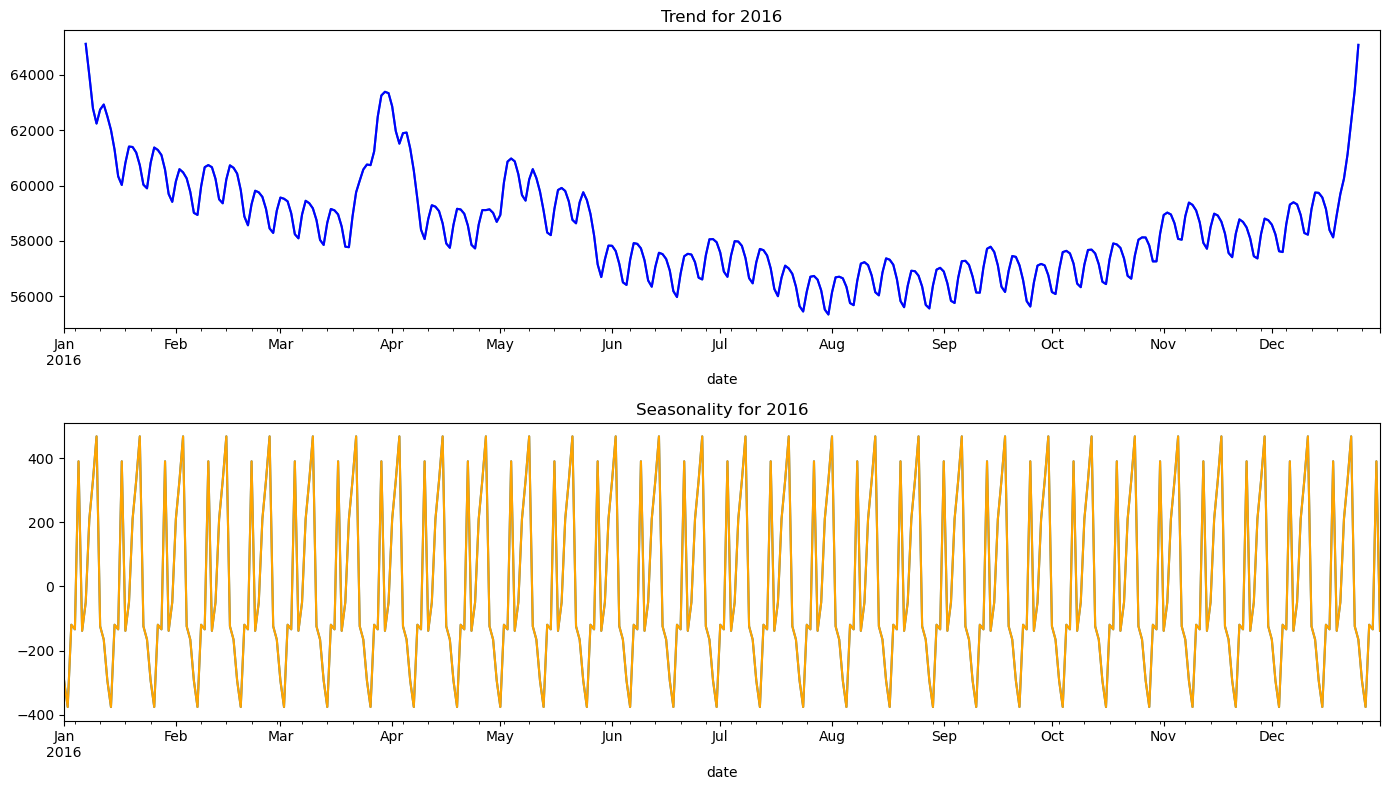

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose


# Set the date column as the index
X_data_index = train.set_index('date')

# Resample the data monthly by summing the sales (num_sold) for each month
monthly_data = X_data_index.resample('D').sum()
monthly_data['year'] = monthly_data.index.year
monthly_data['month'] = monthly_data.index.month

# Loop through each year and perform decomposition
years = monthly_data['year'].unique()
for year in years:
    yearly_data = monthly_data[monthly_data['year'] == year]
    
    decomposition = seasonal_decompose(yearly_data['num_sold'], model='additive', period=12)
    
    #Extract trend and seasonal components
    trend = decomposition.trend.dropna()  # Drop NaN values that result from smoothing
    seasonal = decomposition.seasonal.dropna()

    # Plot Trend and Seasonal components
    plt.figure(figsize=(14, 8))

    # Plot Trend
    plt.subplot(2, 1, 1)
    decomposition.trend.plot()
    plt.plot(trend, label='Trend', color='blue')
    plt.title(f"Trend for {year}")

    # Plot Seasonal
    plt.subplot(2, 1, 2)
    decomposition.seasonal.plot()
    plt.plot(seasonal, label='Seasonal', color='orange')
    plt.title(f"Seasonality for {year}")
    

    plt.tight_layout()  # Ensure proper layout
    plt.show()


## Autocorrelation

<Figure size 1000x600 with 0 Axes>

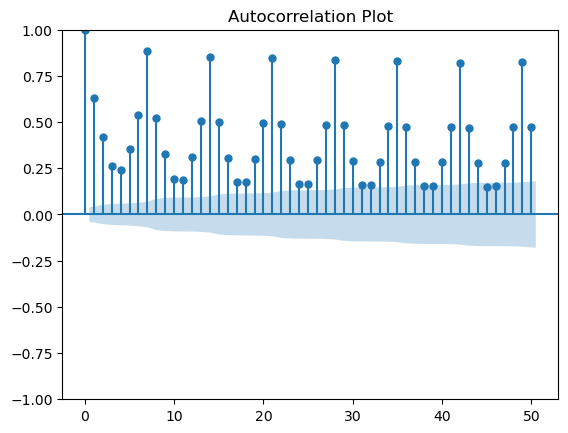

In [22]:
from statsmodels.graphics.tsaplots import plot_acf

# Aggregate data by day to create the time series
trend_data = train.groupby('date')['num_sold'].sum()

plt.figure(figsize=(10, 6))
plot_acf(trend_data.dropna(), lags=50)
plt.title('Autocorrelation Plot')
plt.show()

# Data Processing

In [24]:
# Trandform the data column
def transform_date(df, col):
    # Convert the column to datetime
    df[col] = pd.to_datetime(df[col])

    # Extract temporal features
    df[f"{col}_year"] = df[col].dt.year.astype("float64")
    df[f"{col}_quarter"] = df[col].dt.quarter.astype("float64")
    df[f"{col}_month"] = df[col].dt.month.astype("float64")
    df[f"{col}_day"] = df[col].dt.day.astype("float64")
    df[f"{col}_day_of_week"] = df[col].dt.dayofweek.astype("float64")
    df[f"{col}_week_of_year"] = df[col].dt.isocalendar().week.astype("float64")
    df[f"{col}_hour"] = df[col].dt.hour.astype("float64")
    df[f"{col}_minute"] = df[col].dt.minute.astype("float64")

    # Add cyclical encodings
    df[f"{col}_day_sin"] = np.sin(2 * np.pi * df[f"{col}_day"] / 365.0)
    df[f"{col}_day_cos"] = np.cos(2 * np.pi * df[f"{col}_day"] / 365.0)
    df[f"{col}_month_sin"] = np.sin(2 * np.pi * df[f"{col}_month"] / 12.0)
    df[f"{col}_month_cos"] = np.cos(2 * np.pi * df[f"{col}_month"] / 12.0)
    df[f"{col}_year_sin"] = np.sin(2 * np.pi * df[f"{col}_year"] / 7.0)
    df[f"{col}_year_cos"] = np.cos(2 * np.pi * df[f"{col}_year"] / 7.0)

    # Add group feature (for time-based grouping)
    df[f"{col}_Group"] = (
        (df[f"{col}_year"] - 2010) * 48 + df[f"{col}_month"] * 4 + df[f"{col}_day"] // 7
    )

    # TODO Maybe add important holidays as features 

    return df

In [25]:
new_train = transform_date(train, 'date')
new_test = transform_date(test, 'date')

In [29]:
# We might consider targeting the log of the number of units sold - this would require transformation during prediction, though.
# new_train['num_sold'] = np.log1p(new_train['num_sold'])
new_train = new_train.drop(columns=['date', 'id'], axis=1)
new_test = new_test.drop(columns=['date', 'id'], axis=1)

In [31]:
# Handle missing Values

## We will drop NA values for now
new_train = new_train.dropna()
new_test = new_test.dropna()

In [41]:
num_ftrs = list(new_train.select_dtypes(exclude=['object']).columns.difference(['num_sold']))
cat_ftrs = list(new_train.select_dtypes(include=['object']).columns)

num_ftrs_test = list(new_test.select_dtypes(exclude=['object']).columns.difference(['id']))
cat_ftrs_test = list(new_test.select_dtypes(include=['object']).columns)



In [71]:
# Combined train and test data for consistent preprocessing, then split back into respective datasets.

train_test_comb = pd.concat([new_train, new_test], axis=0, ignore_index=True)
for col in cat_ftrs:
    # Convert categorical to ints
    train_test_comb[col], _ = train_test_comb[col].factorize()
    train_test_comb[col] -= train_test_comb[col].min()
    # label encode to categorical and convert int32 to category
    train_test_comb[col] = train_test_comb[col].astype('int32')
    train_test_comb[col] = train_test_comb[col].astype('category')

for col in num_ftrs:
    if train_test_comb[col].dtype=='float64':
        train_test_comb[col].astype('float32')
    if train_test_comb[col].dtype=='int64':
        train_test_comb[col].astype('int32')

new_train = train_test_comb.iloc[:len(new_train)].copy()
new_test = train_test_comb.iloc[len(new_train):].copy()
new_test = new_test.drop(columns='num_sold', axis=1) # Drop the target column, it came from the merge


In [72]:
new_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221259 entries, 0 to 221258
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   country            221259 non-null  category
 1   store              221259 non-null  category
 2   product            221259 non-null  category
 3   num_sold           221259 non-null  float64 
 4   date_year          221259 non-null  float64 
 5   date_quarter       221259 non-null  float64 
 6   date_month         221259 non-null  float64 
 7   date_day           221259 non-null  float64 
 8   date_day_of_week   221259 non-null  float64 
 9   date_week_of_year  221259 non-null  float64 
 10  date_hour          221259 non-null  float64 
 11  date_minute        221259 non-null  float64 
 12  date_day_sin       221259 non-null  float64 
 13  date_day_cos       221259 non-null  float64 
 14  date_month_sin     221259 non-null  float64 
 15  date_month_cos     221259 non-null

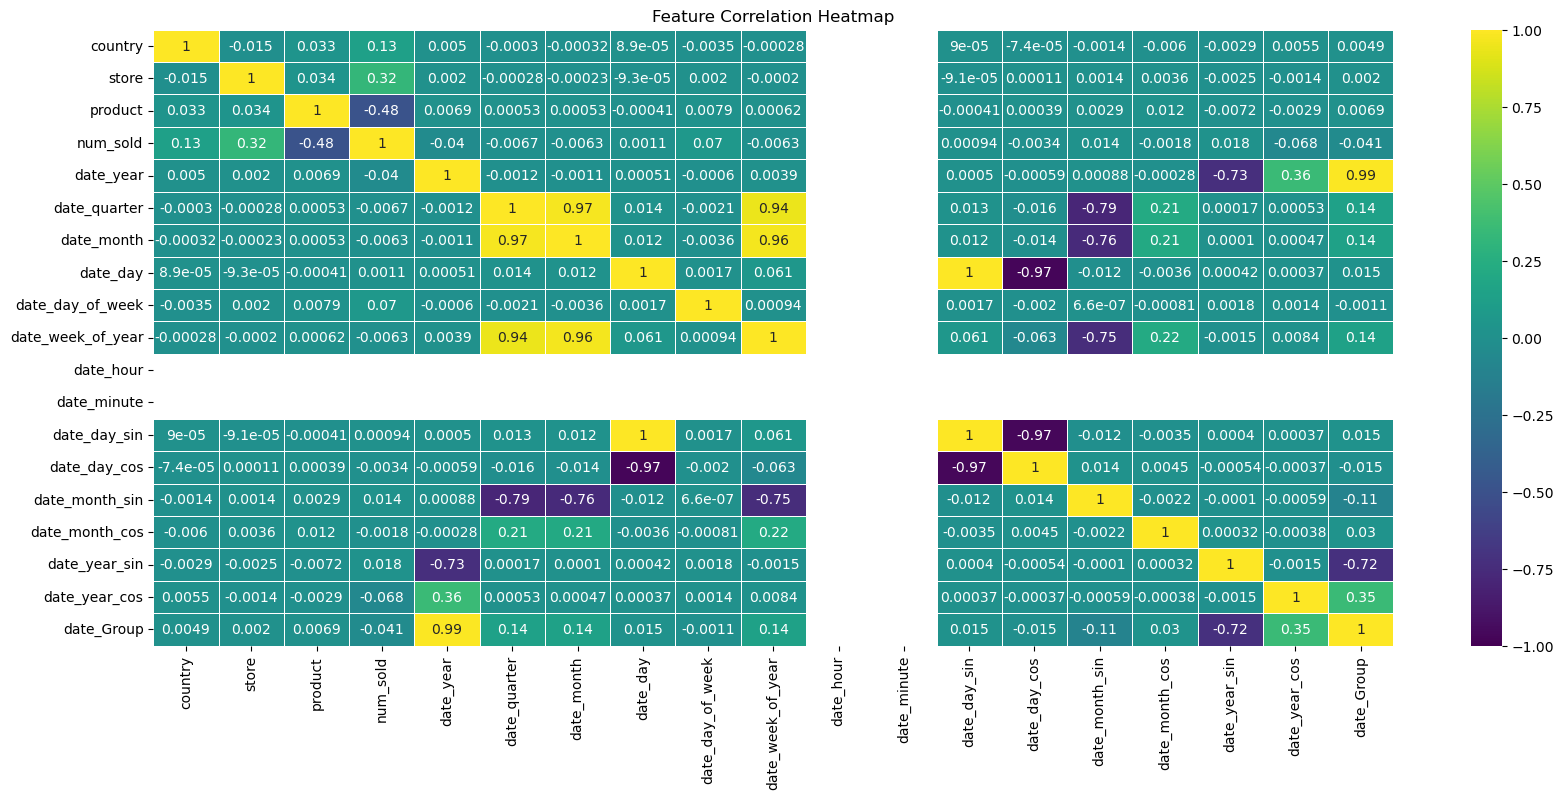

In [69]:
# Correlation Matrix of Processed Data
correlation_matrix = new_train.corr()

# Plot the heatmap
plt.figure(figsize=(20, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Feature Correlation Heatmap')
#plt.tight_layout()
plt.show()


# Export the Data

In [73]:
# Export the DataFrame to a pickle file
new_train.to_pickle("data/processed/processed_train_data_v1.pkl")
new_test.to_pickle("data/processed/processed_test_data_v1.pkl")